ToDo 

[] reduce size of finetuning dataset 

[] see how performance changes as a function of the % of the finetuning dataset used

[x] create an end2end baseline 

[] change to 1 layer 

[x] update early stopping

[] investigate SGD

[] other stuff on slack 

[] randomsearch with wandb

In [1]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Testing dataset generation 

In [2]:
def eval(model, device, dataset_loader, debug, classification_report_flag = False):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


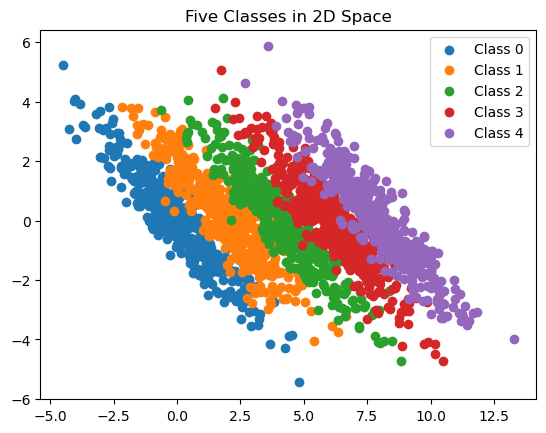

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_samples_per_class=100, n_classes=5):
    """
    Generate data for n_classes in a 2D space where the means of the data clouds
    are distributed along a horizontal line, and the data clouds have a wide 
    vertical distribution along a 45-degree slope.

    Parameters:
    - n_samples_per_class: Number of samples per class.
    - n_classes: Number of classes.

    Returns:
    - X: Data points.
    - y: Class targets.
    """
    
    # Define means for the classes along a horizontal line
    means = [(i*2, 0) for i in range(n_classes)]

    # Define a covariance matrix for 45-degree slope spread
    rotation_matrix = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                                [np.sin(np.pi/4),  np.cos(np.pi/4)]])
    base_covariance = np.array([[0.2, 0], 
                                [0, 5]])
    covariance = rotation_matrix @ base_covariance @ rotation_matrix.T

    X = np.empty((0, 2))
    y = np.empty((0,))

    for idx, mean in enumerate(means):
        class_data = np.random.multivariate_normal(mean, covariance, n_samples_per_class)
        X = np.vstack([X, class_data])
        y = np.hstack([y, [idx]*n_samples_per_class])

    return X, y

# Generate and plot the data
n_classes = 5
X, y = generate_data(n_samples_per_class = 400, n_classes=n_classes)

for idx in range(5):
    plt.scatter(X[y == idx][:, 0], X[y == idx][:, 1], label=f'Class {idx}')

plt.title("Five Classes in 2D Space")
plt.legend()
plt.show()


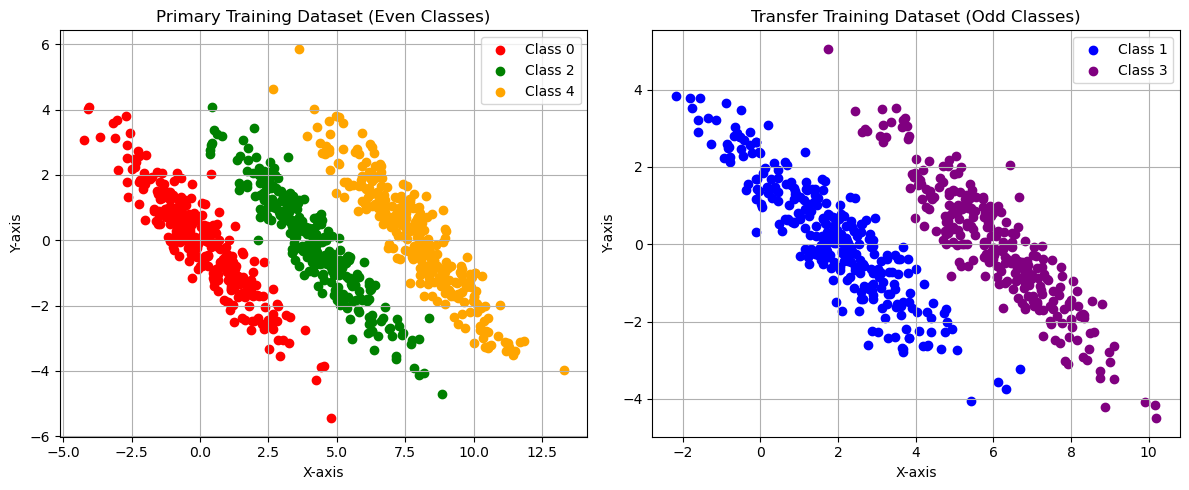

In [4]:
# Split the data into primary (even classes) and transfer (odd classes) datasets
X_primary = X[np.isin(y, [0, 2, 4])]
y_primary = y[np.isin(y, [0, 2, 4])]

X_transfer = X[np.isin(y, [1, 3])]
y_transfer = y[np.isin(y, [1, 3])]

# Splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Primary dataset: Split into train, validation, and test sets
X_primary_train, X_primary_temp, y_primary_train, y_primary_temp = train_test_split(X_primary, y_primary, test_size=(1-train_ratio))
X_primary_val, X_primary_test, y_primary_val, y_primary_test = train_test_split(X_primary_temp, y_primary_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Transfer dataset: Split into train, validation, and test sets
X_transfer_train, X_transfer_temp, y_transfer_train, y_transfer_temp = train_test_split(X_transfer, y_transfer, test_size=(1-train_ratio))
X_transfer_val, X_transfer_test, y_transfer_val, y_transfer_test = train_test_split(X_transfer_temp, y_transfer_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Plotting
# For brevity, I'm only plotting the training datasets for primary and transfer.
plt.figure(figsize=(12, 5))

# Primary training dataset
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in [0, 2, 4]:
    plt.scatter(X_primary_train[y_primary_train==i][:, 0], X_primary_train[y_primary_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Primary Training Dataset (Even Classes)')
plt.grid(True)

# Transfer training dataset
plt.subplot(1, 2, 2)
for i in [1, 3]:
    plt.scatter(X_transfer_train[y_transfer_train==i][:, 0], X_transfer_train[y_transfer_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Transfer Training Dataset (Odd Classes)')
plt.grid(True)

plt.tight_layout()
plt.show()



ADAM IS THE KEY 

In [5]:
# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break
        
        if save_checkpoints:
            # Save checkpoint after each epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

def plot_decision_boundary_dataloader(model, dataloader, n_classes, percentage = None, Seed = None):
    # Extract data from dataloader
    X_list = []
    y_list = []
    for data, target in dataloader:
        X_list.append(data.numpy())
        y_list.append(target.numpy())
    
    # Concatenate all the data points
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Rest is similar to the original function
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    if percentage and Seed:
        plt.title(f"Decision Boundary (percentage {percentage:.2f}%, Seed: {Seed})")
    elif percentage:
        plt.title(f"Decision Boundary (percentage {percentage:.2f}%)")
    else:
        plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# Usage
# plot_decision_boundary_dataloader(model, dataloader, n_classes=2)


In [7]:
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False, plot_boundary=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   

    best_model_state = None  # To save the best model weights/state
    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))
        if plot_boundary:
            plot_decision_boundary_dataloader(model, dataset.train_loader,  n_classes=2)

        if params['early_stop_patience']:
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() # This line saves the best model state.
                no_improve_epochs = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                no_improve_epochs += 1
                print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    print("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break
        
        if save_checkpoints:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # At the end of training, load the best weights if early stopping wasn't invoked 
    # (in case the final epochs did not improve performance)
    if params['early_stop_patience']:
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []


In [8]:
import torch.utils.data as data

def reduce_dataset(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Determine the number of samples to keep
    num_samples = int(len(dataset) * percentage)
    
    # Randomly select indices without replacement
    indices = torch.randperm(len(dataset))[:num_samples]

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

import torch
from torch.utils import data

def reduce_dataset_balanced(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage ensuring class balance.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Get unique classes and their counts
    classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)
    
    # Determine the number of samples per class to keep
    num_samples_per_class = int(len(dataset) * percentage / len(classes))
    selected_indices = []

    for class_label in classes:
        class_indices = [i for i, label in enumerate(y) if label == class_label]
        
        # Randomly select indices without replacement for each class
        class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
        selected_indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, selected_indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader



## Pretraining

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
device = 'cpu'

depth = 2

params = dict(device=device,
                width=20, lr=0.01, num_train=100,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 10, activation_function='tanh')

import torch
from torch.utils.data import TensorDataset, DataLoader

#relable the data
mapping = {0: 0, 2: 1, 4: 2}

y_primary_train_pretain = torch.LongTensor([mapping[c] for c in y_primary_train])
y_primary_val_pretain = torch.LongTensor([mapping[c] for c in y_primary_val])
y_primary_test_pretain = torch.LongTensor([mapping[c] for c in y_primary_test])

# Convert primary training data to PyTorch tensors
X_primary_train_tensor = torch.FloatTensor(X_primary_train)
y_primary_train_tensor = torch.LongTensor(y_primary_train_pretain)

# Convert primary validation data to PyTorch tensors
X_primary_val_tensor = torch.FloatTensor(X_primary_val)
y_primary_val_tensor = torch.LongTensor(y_primary_val_pretain)

# Convert primary test data to PyTorch tensors
X_primary_test_tensor = torch.FloatTensor(X_primary_test)
y_primary_test_tensor = torch.LongTensor(y_primary_test_pretain)


# Create DataLoaders for primary datasets
train_dataset = TensorDataset(X_primary_train_tensor, y_primary_train_tensor)
val_dataset = TensorDataset(X_primary_val_tensor, y_primary_val_tensor)
test_dataset = TensorDataset(X_primary_test_tensor, y_primary_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim-2, params, gaussian_init=False, activation_function = nn.ReLU)

# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 66.63%
Validation Accuracy: 66.11%
Epoch: 1 	Training Accuracy: 78.43%
Validation Accuracy: 78.33%
Epoch: 2 	Training Accuracy: 99.52%
Validation Accuracy: 99.44%
Epoch: 3 	Training Accuracy: 99.17%
Validation Accuracy: 99.44%
val_acc: 0.9944444444444445, max_val_acc: 0.9944444444444445, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 99.64%
Validation Accuracy: 99.44%
val_acc: 0.9944444444444445, max_val_acc: 0.9944444444444445, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 99.76%
Validation Accuracy: 99.44%
val_acc: 0.9944444444444445, max_val_acc: 0.9944444444444445, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 99.88%
Validation Accuracy: 99.44%
val_acc: 0.9944444444444445, max_val_acc: 0.9944444444444445, no_improve_epochs: 4
Epoch: 7 	Training Accuracy: 99.76%
Validation Accuracy: 99.44%
val_acc: 0.9944444444444445, max_val_acc: 0.9944444444444445, no_improve_epochs: 5
Epoch: 8 	Training Accuracy: 99.76%
Validation Accuracy: 99.44%
val_acc: 

In [11]:
print(model)

Sequential(
  (linear0): Linear(in_features=2, out_features=20, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=20, out_features=3, bias=True)
  (activation1): LogSoftmax(dim=1)
)


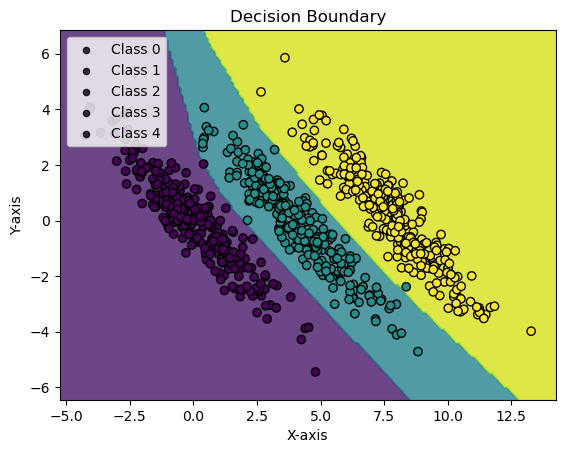

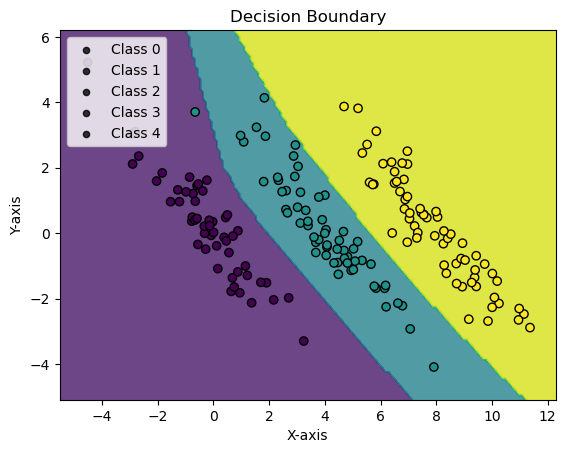

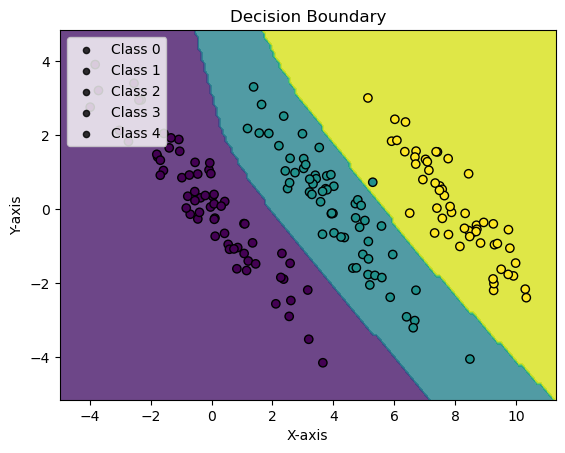

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# After training
plot_decision_boundary(model, X_primary_train, y_primary_train, n_classes)
plot_decision_boundary(model, X_primary_val, y_primary_val, n_classes)
plot_decision_boundary(model, X_primary_test, y_primary_test, n_classes)


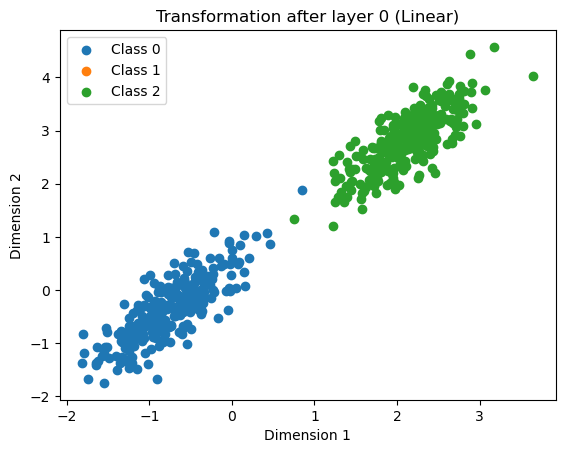

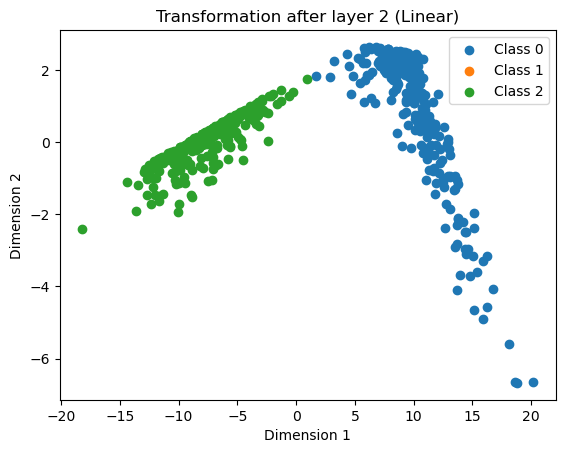

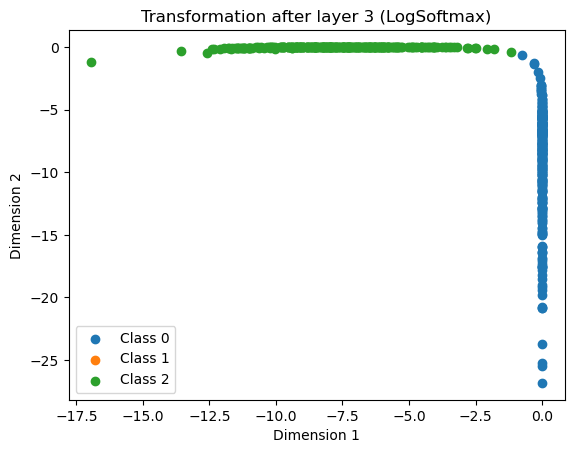

In [13]:
import matplotlib.pyplot as plt

def plot_layer_transformations(model, X, y, layer_indices):
    n_classes = len(np.unique(y))
    X_transformed = torch.FloatTensor(X)
    
    for i, layer_index in enumerate(layer_indices):
        layer = model[layer_index]
        
        with torch.no_grad():
            X_transformed = layer(X_transformed)
            
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.LogSoftmax):
            X_transformed_numpy = X_transformed.detach().cpu().numpy()
            
            plt.figure()
            for class_idx in range(n_classes):
                idxs = np.where(y == class_idx)[0]
                plt.scatter(X_transformed_numpy[idxs, 0], X_transformed_numpy[idxs, 1], label=f"Class {class_idx}")
            
            layer_type = type(layer).__name__
            plt.title(f'Transformation after layer {layer_index} ({layer_type})')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()

# Indicate which layers you are interested in (by index).
layer_indices = list(range(depth*2))

# X should be your original data and y should be the labels.
plot_layer_transformations(model, X_primary_train, y_primary_train, layer_indices)

plt.show()


In [14]:
eval(model, device, test_loader, debug=True, classification_report_flag = True)


Average loss: 0.0179, Accuracy: 180.0/181 (99%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        66
     Class 1       1.00      0.98      0.99        61
     Class 2       0.98      1.00      0.99        54

    accuracy                           0.99       181
   macro avg       0.99      0.99      0.99       181
weighted avg       0.99      0.99      0.99       181



0.994475138121547

In [15]:
#save model
# torch.save(model, f"model_{depth}_synthetic_data_against_overfitting.pt")

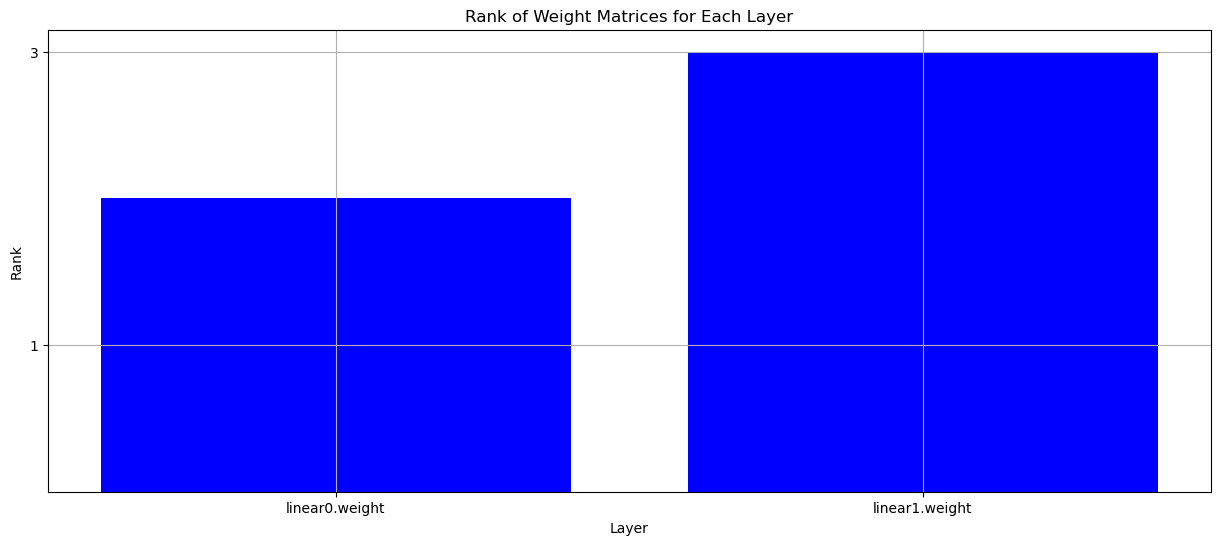

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


linear0.weight: 1.9041
linear1.weight: 2.6358


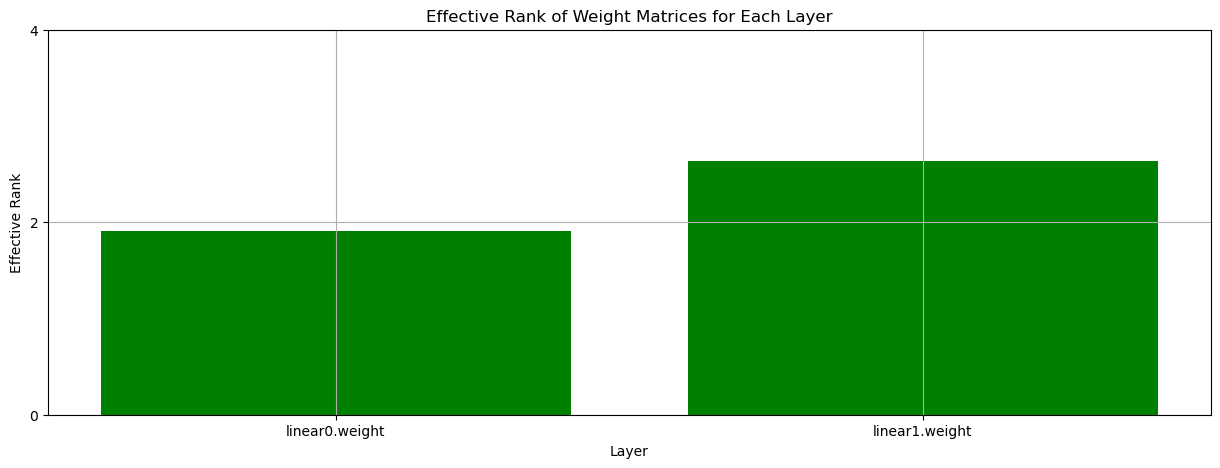

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

## Baseline model: end2end with the same architecture as the preatining model

In [18]:
#relabeling 

mapping = {1: 0, 3: 1}

y_transfer_train_v1 = np.array([mapping[label] for label in y_transfer_train])
y_transfer_val_v1 = np.array([mapping[label] for label in y_transfer_val])
y_transfer_test_v1 = np.array([mapping[label] for label in y_transfer_test])

In [19]:
# Convert transfer training data to PyTorch tensors
X_transfer_train_tensor = torch.FloatTensor(X_transfer_train)
y_transfer_train_tensor = torch.LongTensor(y_transfer_train_v1)

# Convert trasnfer validation data to PyTorch tensors
X_transfer_val_tensor = torch.FloatTensor(X_transfer_val)
y_transfer_val_tensor = torch.LongTensor(y_transfer_val_v1)

# Convert trasnfer test data to PyTorch tensors
X_transfer_test_tensor = torch.FloatTensor(X_transfer_test)
y_transfer_test_tensor = torch.LongTensor(y_transfer_test_v1)

# Create DataLoaders for transfer datasets
train_dataset_transfer = TensorDataset(X_transfer_train_tensor, y_transfer_train_tensor)
val_dataset_transfer = TensorDataset(X_transfer_val_tensor, y_transfer_val_tensor)
test_dataset_transfer = TensorDataset(X_transfer_test_tensor, y_transfer_test_tensor)

train_loader_transfer = DataLoader(train_dataset_transfer, batch_size=32, shuffle=True)
val_loader_transfer = DataLoader(val_dataset_transfer, batch_size=32, shuffle=False)
test_loader_transfer = DataLoader(test_dataset_transfer, batch_size=32, shuffle=False)

In [20]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
new_n_classes = 2  # Number of classes in the new dataset
model_finetuning_baseline = generate_fc_dnn(input_dim, new_n_classes, params,gaussian_init=False, activation_function = nn.ReLU)

# 3. Fine-tune on the new data

dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer, test_loader=test_loader_transfer, val_loader=test_loader_transfer)

# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_finetuning_baseline, _ = compute_training_acc_epochs(model_finetuning_baseline, dataset_namespace_new, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Epoch: 0 	Training Accuracy: 61.72%
Validation Accuracy: 65.29%
Epoch: 1 	Training Accuracy: 86.58%
Validation Accuracy: 89.26%
Epoch: 2 	Training Accuracy: 96.42%
Validation Accuracy: 92.56%
Epoch: 3 	Training Accuracy: 99.28%
Validation Accuracy: 100.00%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 2


Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 4
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 5
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 6
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 7
Epoch: 11 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 8
Epoch: 12 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 9
Epoch: 13 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 10
Early stopping invoked.
Final Training Accu

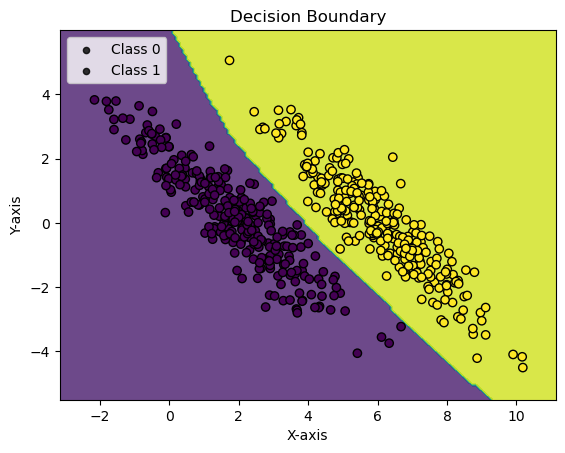

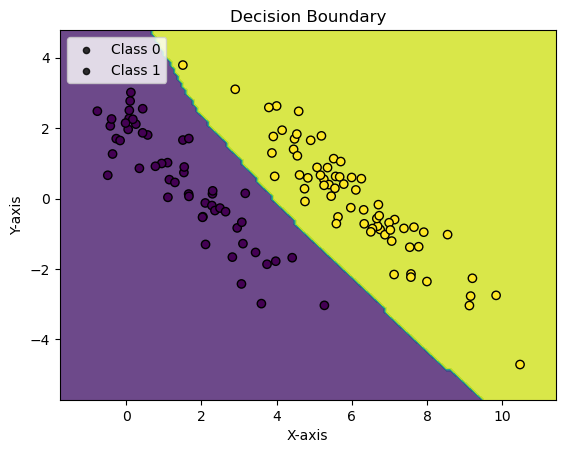

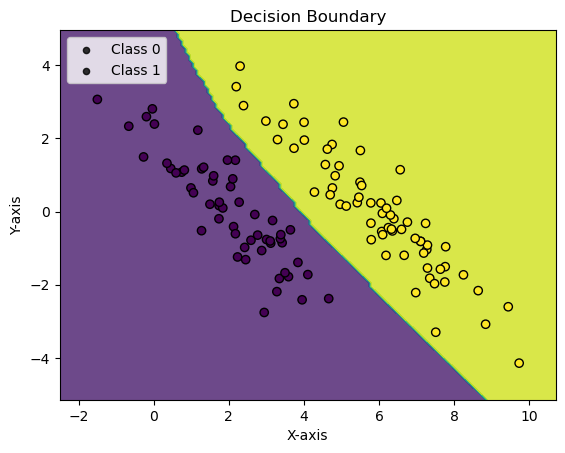

In [21]:
plot_decision_boundary(model_finetuning_baseline, X_transfer_train, y_transfer_train, n_classes=2)
plot_decision_boundary(model_finetuning_baseline, X_transfer_val, y_transfer_val, n_classes=2)
plot_decision_boundary(model_finetuning_baseline, X_transfer_test, y_transfer_test, n_classes=2)


Average loss: 0.0057, Accuracy: 121.0/121 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        55
     Class 1       1.00      1.00      1.00        66

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

linear0.weight: 1.9650
linear1.weight: 1.5062


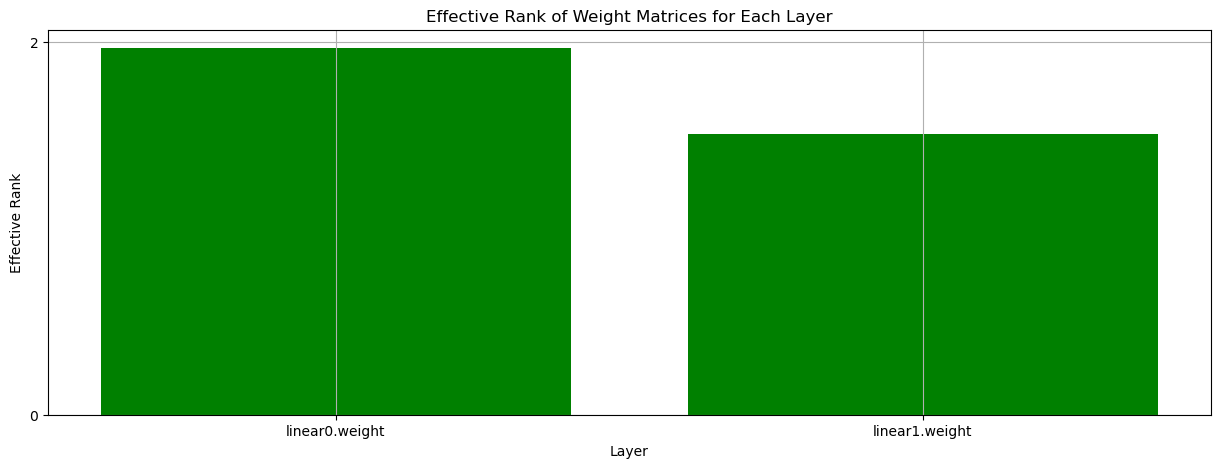

In [22]:
eval(model_finetuning_baseline, device, test_loader_transfer, debug=True, classification_report_flag = True)
plot_layer_effective_ranks(model_finetuning_baseline)
# results, variances = compute_layer_variances_dense(model_finetuning_baseline, test_loader_transfer, device = 'cpu',cnn=False)
# plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

now with balanced classes

Percentage: 0.005
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 69.17%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 67.50%
val_acc: 0.675, max_val_acc: 0.6916666666666667, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 59.17%
val_acc: 0.5916666666666667, max_val_acc: 0.6916666666666667, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 43.33%
val_acc: 0.43333333333333335, max_val_acc: 0.6916666666666667, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 44.17%
val_acc: 0.44166666666666665, max_val_acc: 0.6916666666666667, no_improve_epochs: 4
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 43.33%
val_acc: 0.

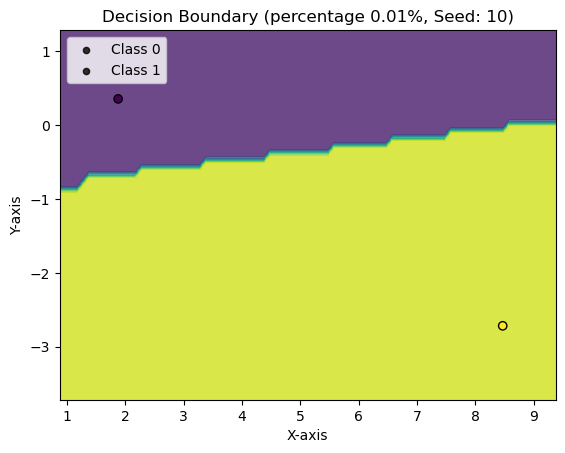

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
val_acc: 0.44166666666666665, max_val_acc: 0.44166666666666665, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 69.17%
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 71.67%
Epoch: 4 	Training Accuracy: 50.00%
Validation Accuracy: 75.00%
Epoch: 5 	Training Accuracy: 50.00%
Validation Accuracy: 76.67%
Epoch: 6 	Training Accuracy: 50.00%
Validation Accuracy: 78.33%
Epoch: 7 	Training Accuracy: 50.00%
Validation Accuracy: 79.17%
Epoch: 8 	Training Accuracy: 50.00%
Validation Accuracy: 78.33%
val_acc: 0.7833333333333333, max_val_acc: 0.7916666666666666, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7916666666666666, no_improve_epochs: 2
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy

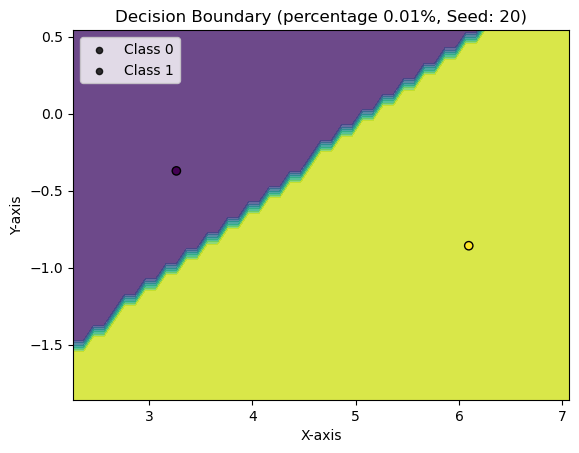

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 69.17%
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 70.83%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 70.83%
val_acc: 0.7083333333333334, max_val_acc: 0.7083333333333334, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 71.67%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 73.33%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.74166666

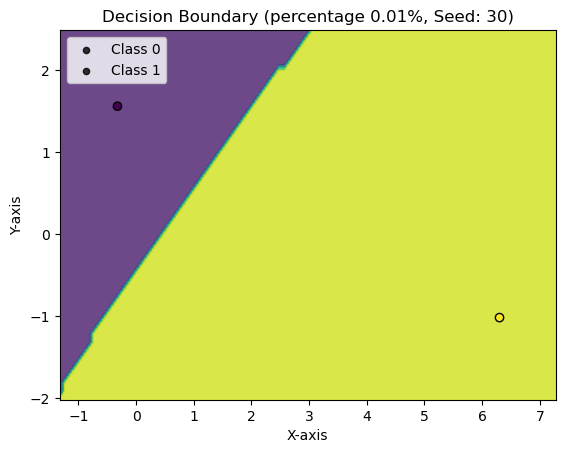

Percentage: 0.01
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 61.67%
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 73.33%
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 80.83%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 75.00%
val_acc: 0.75, max_val_acc: 0.8083333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 75.00%
Validation Accuracy: 73.33%
val_acc: 0.7333333333333333, max_val_acc: 0.8083333333333333, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 75.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.8083333333333333, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 75.00%
Validation Accuracy: 73.33%
val_acc: 0.7333333333333333, max_val_acc: 0.8083333

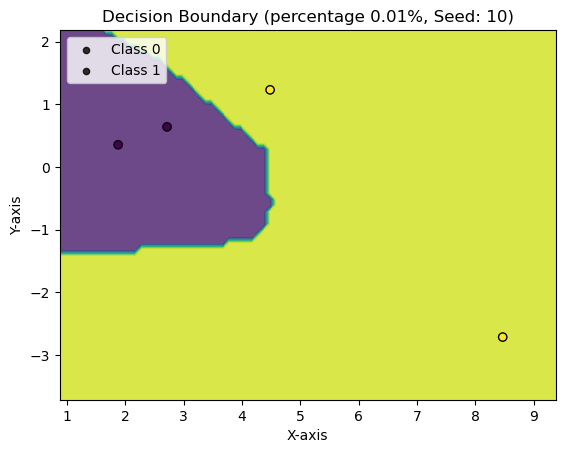

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 32.50%
val_acc: 0.325, max_val_acc: 0.5666666666666667, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 50.00%
Validation Accuracy: 31.67%
val_acc: 0.31666666666666665, max_val_acc: 0.5666666666666667, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 50.00%
Validation Accuracy: 30.83%
val_acc: 0.30833333333333335, max_val_acc: 0.5666666666666667, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 75.00%
Validation Accuracy: 38.33%
val_acc: 0.38333333333333336, max_val_acc: 0.5666666666666667, no_improve_epochs: 4
Epoch: 7 	Training Accuracy: 75.00%
Validation Accuracy: 62.50%
Epoch: 8 	Training Accuracy: 75.0

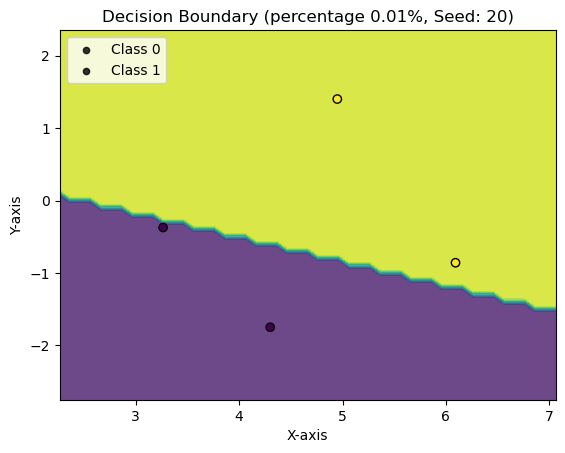

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 60.83%
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 71.67%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 73.33%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 73.33%
val_acc: 0.7333333333333333, max_val_acc: 0.7333333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.7333333333333333, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.7333333333333333, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.7333333333333333, no_improve_epochs: 4
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 72.50%
val_acc:

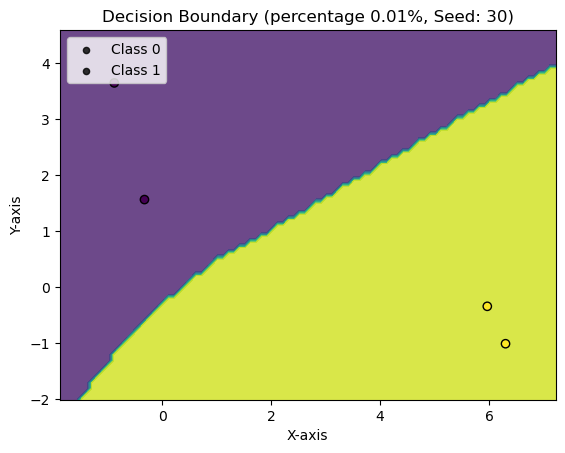

Percentage: 0.015
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 62.50%
Validation Accuracy: 59.17%
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 62.50%
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.625, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 75.00%
Validation Accuracy: 60.00%
val_acc: 0.6, max_val_acc: 0.625, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 87.50%
Validation Accuracy: 69.17%
Epoch: 8 	Training Accuracy: 75.00%
Validation Accuracy: 83.33%
Epoch: 9 	Training Accuracy: 87.50%
Validation Accuracy: 85.00%
E

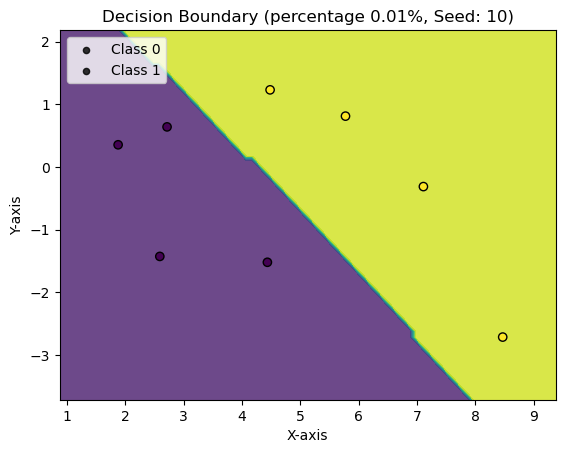

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 70.83%
Epoch: 1 	Training Accuracy: 62.50%
Validation Accuracy: 74.17%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 78.33%
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 87.50%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 94.17%
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 86.67%
val_acc: 0.8666666666666667, max_val_acc: 0.9416666666666667, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 8 	Training Accuracy: 87.50%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 87.50%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 10 	Training Accuracy: 75.00%
Validation Accuracy: 

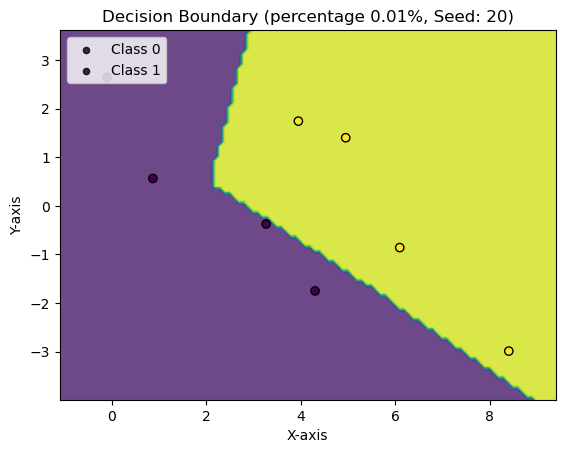

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 75.00%
Validation Accuracy: 69.17%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 70.83%
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 73.33%
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 75.00%
Epoch: 5 	Training Accuracy: 87.50%
Validation Accuracy: 80.00%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 84.17%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 80.00%
val_acc: 0.8, max_val_acc: 0.8416666666666667, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 80.00%
val_acc: 0.8, max_val_acc: 0.8416666666666667, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 80.83%
val_acc: 0.8083333333333333, max_val_acc: 0.8416666666666667, no_improve_epochs: 3
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 83.33%
val_acc: 0.8333333333

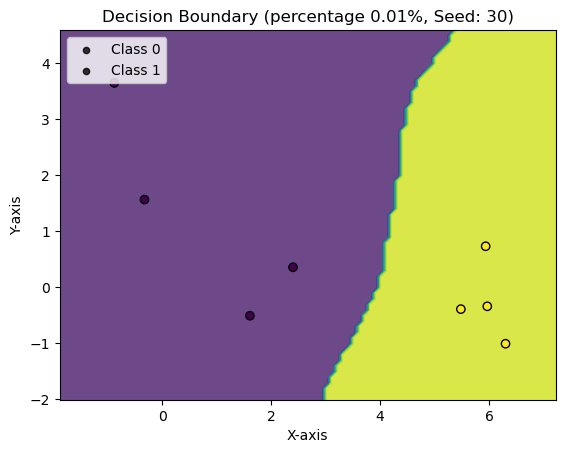

Percentage: 0.02
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 4 	Training Accuracy: 80.00%
Validation Accuracy: 74.17%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 59.17%
val_acc: 0.5916666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 80.00%
Validation Accuracy: 48.33%
val_acc: 0.48333333333333334, max_val_acc: 0.7416666666666667, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 70.00%
Validation Accuracy: 51.67%
val_acc: 0.5166666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 3
Epoc

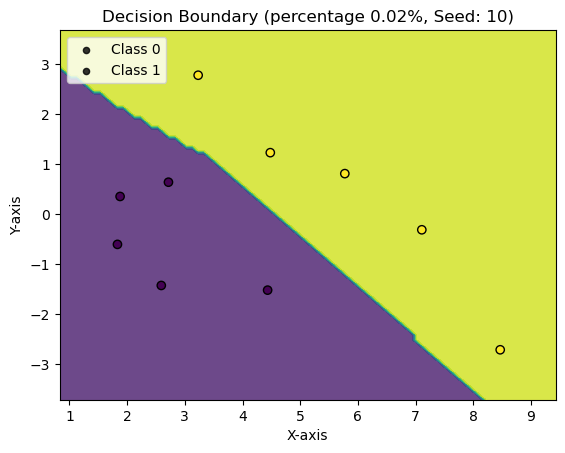

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 57.50%
Epoch: 2 	Training Accuracy: 80.00%
Validation Accuracy: 73.33%
Epoch: 3 	Training Accuracy: 80.00%
Validation Accuracy: 85.00%
Epoch: 4 	Training Accuracy: 70.00%
Validation Accuracy: 82.50%
val_acc: 0.825, max_val_acc: 0.85, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 70.00%
Validation Accuracy: 89.17%
Epoch: 6 	Training Accuracy: 90.00%
Validation Accuracy: 96.67%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.9666666666666667, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 90.00%
Validation Accuracy: 99.17%
Epoch: 9 	Training Accuracy: 90.00%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 90.00%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_va

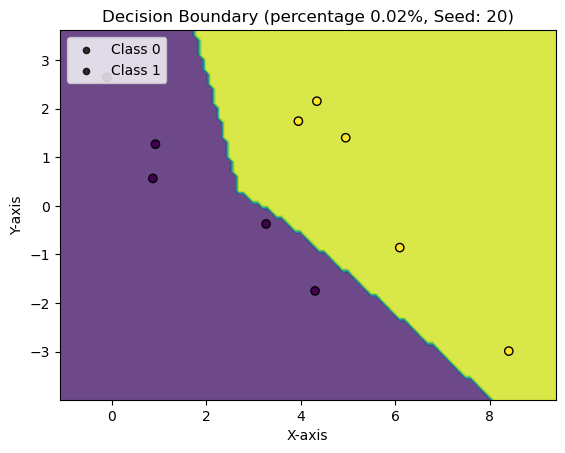

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 70.00%
Validation Accuracy: 60.83%
Epoch: 2 	Training Accuracy: 70.00%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 70.00%
Validation Accuracy: 70.83%
Epoch: 4 	Training Accuracy: 70.00%
Validation Accuracy: 74.17%
Epoch: 5 	Training Accuracy: 70.00%
Validation Accuracy: 75.83%
Epoch: 6 	Training Accuracy: 90.00%
Validation Accuracy: 79.17%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 77.50%
val_acc: 0.775, max_val_acc: 0.7916666666666666, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 80.00%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 81.67%
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 85.83%
Epoch: 11 	Training Accuracy: 100.00%
Validation Accuracy: 84.17%
val_acc: 0.8416666666666667, max_val_acc: 0.8583333333333333, no_improve_epochs: 1
Epoch: 12 	Training Ac

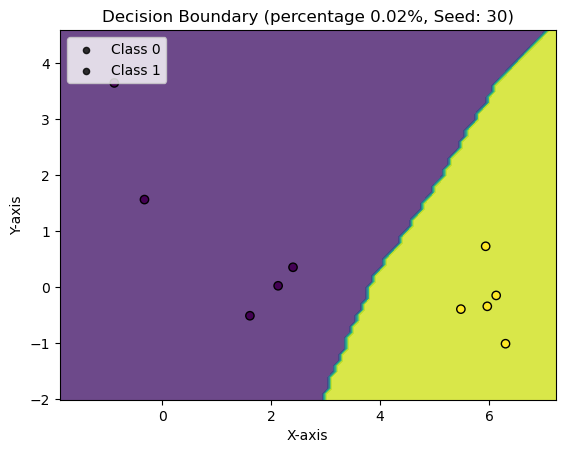

Percentage: 0.03
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 60.00%
Epoch: 1 	Training Accuracy: 81.25%
Validation Accuracy: 75.00%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 60.00%
val_acc: 0.6, max_val_acc: 0.75, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 81.25%
Validation Accuracy: 75.00%
val_acc: 0.75, max_val_acc: 0.75, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 93.75%
Validation Accuracy: 85.83%
Epoch: 5 	Training Accuracy: 81.25%
Validation Accuracy: 88.33%
Epoch: 6 	Training Accuracy: 81.25%
Validation Accuracy: 92.50%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max

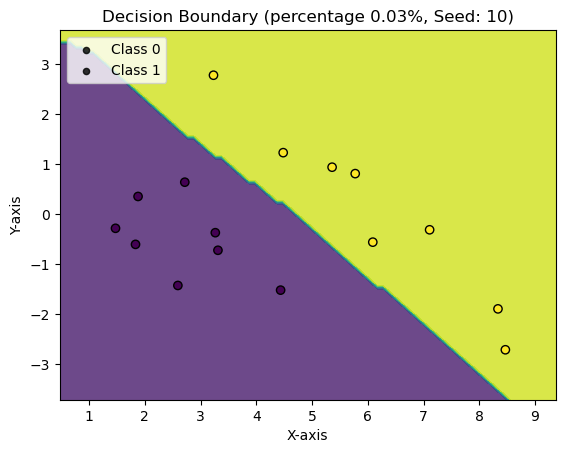

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 87.50%
Validation Accuracy: 75.83%
Epoch: 1 	Training Accuracy: 87.50%
Validation Accuracy: 83.33%
Epoch: 2 	Training Accuracy: 93.75%
Validation Accuracy: 95.83%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
Epoch: 5 	Training Accuracy: 93.75%
Validation Accuracy: 98.33%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
val_acc: 0.9916666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 100.00%
Validation Accura

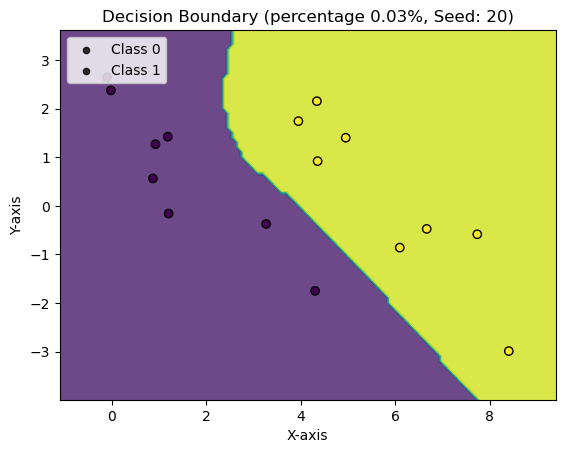

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 62.50%
Validation Accuracy: 61.67%
Epoch: 2 	Training Accuracy: 62.50%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 68.75%
Validation Accuracy: 72.50%
Epoch: 4 	Training Accuracy: 68.75%
Validation Accuracy: 73.33%
Epoch: 5 	Training Accuracy: 93.75%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.7333333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 93.75%
Validation Accuracy: 78.33%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 89.17%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 90.00%
Epoch: 9 	Training Accuracy: 93.75%
Validation Accuracy: 89.17%
val_acc: 0.8916666666666667, max_val_acc: 0.9, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 93.75%
Validation Accuracy: 87.50%
val_acc: 0.875, max_val_acc: 0.9, no_improve_epochs: 2
Epoch: 11 	Training Accuracy: 93.75%
Validation Ac

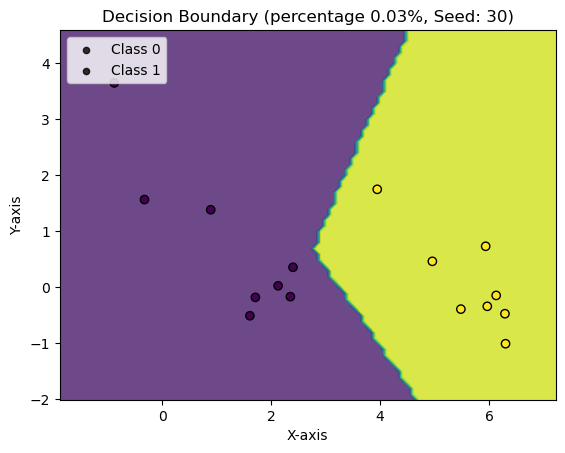

Percentage: 0.07
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 60.53%
Validation Accuracy: 73.33%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
val_acc: 0.44166666666666665, max_val_acc: 0.7333333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
val_acc: 0.9916666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_e

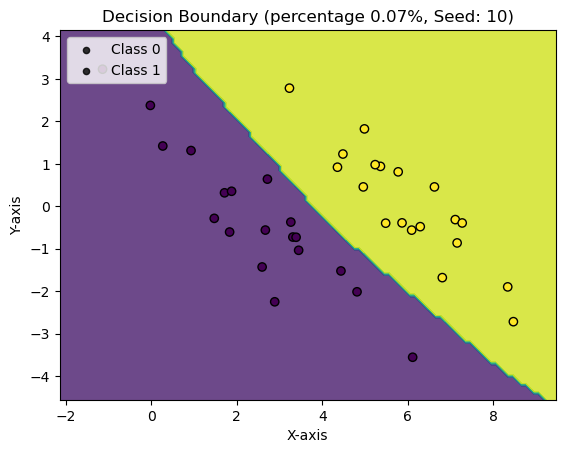

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 52.63%
Validation Accuracy: 60.00%
Epoch: 2 	Training Accuracy: 65.79%
Validation Accuracy: 74.17%
Epoch: 3 	Training Accuracy: 94.74%
Validation Accuracy: 94.17%
Epoch: 4 	Training Accuracy: 71.05%
Validation Accuracy: 60.00%
val_acc: 0.6, max_val_acc: 0.9416666666666667, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 89.47%
Validation Accuracy: 92.50%
val_acc: 0.925, max_val_acc: 0.9416666666666667, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 7 	Training Accuracy: 86.84%
Validation Accuracy: 94.17%
val_acc: 0.9416666666666667, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 84.21%
Validation Accuracy: 86.67%
val_acc: 0.8666666666666667, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 84.21%
Validation Accuracy: 89.17%
val_a

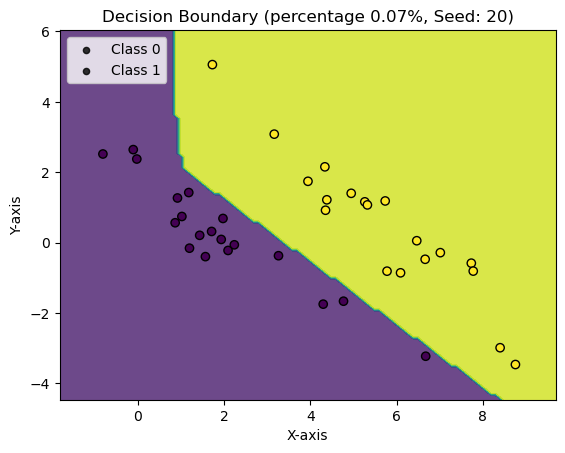

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 100.00%
Validation Accuracy: 95.83%
Epoch: 1 	Training Accuracy: 78.95%
Validation Accuracy: 84.17%
val_acc: 0.8416666666666667, max_val_acc: 0.9583333333333334, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.975, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.975, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epo

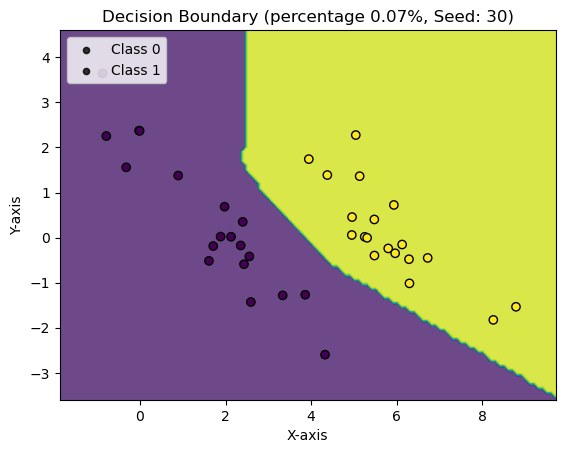

Percentage: 0.1
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 61.11%
Validation Accuracy: 74.17%
Epoch: 1 	Training Accuracy: 75.93%
Validation Accuracy: 70.00%
val_acc: 0.7, max_val_acc: 0.7416666666666667, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 87.04%
Validation Accuracy: 95.00%
Epoch: 3 	Training Accuracy: 81.48%
Validation Accuracy: 89.17%
val_acc: 0.8916666666666667, max_val_acc: 0.95, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 96.30%
Validation Accuracy: 95.00%
val_acc: 0.95, max_val_acc: 0.95, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 94.44%
Validation Accuracy: 93.33%
val_acc: 0.9333333333333333, max_val_acc: 0.95, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 96.30%
Validation Accuracy: 97.50%
Epoch: 7 	Training Accuracy: 98.15%
Validation Accuracy: 98.33%
Epoch: 8 	Training Accuracy: 98.15%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 9 	Trai

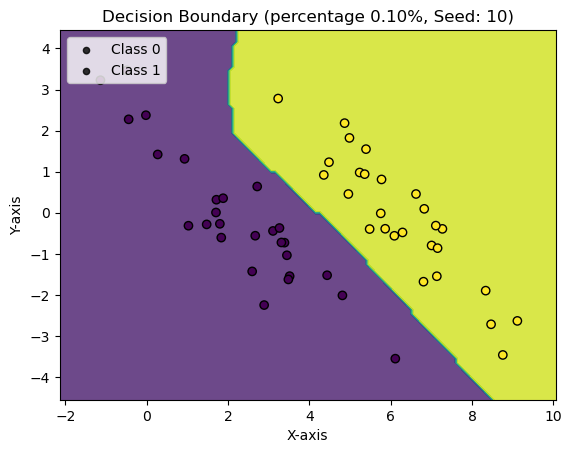

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 88.89%
Validation Accuracy: 84.17%
Epoch: 1 	Training Accuracy: 79.63%
Validation Accuracy: 85.83%
Epoch: 2 	Training Accuracy: 74.07%
Validation Accuracy: 77.50%
val_acc: 0.775, max_val_acc: 0.8583333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 83.33%
Validation Accuracy: 84.17%
val_acc: 0.8416666666666667, max_val_acc: 0.8583333333333333, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 96.30%
Validation Accuracy: 99.17%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch: 6 	Training Accuracy: 98.15%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 98.15%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
val_acc: 1.0, max_val_acc: 1.0, no_improve_epochs: 3
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy

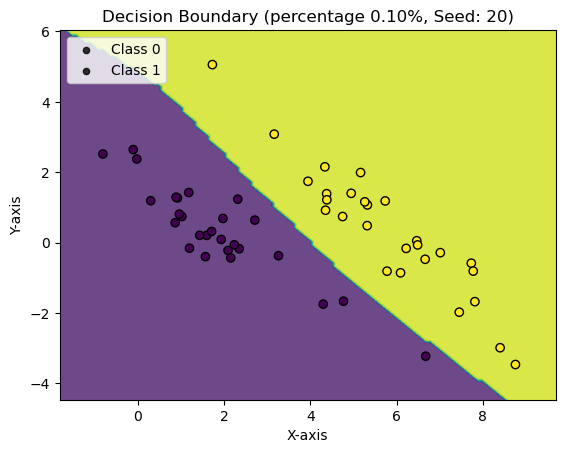

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 88.89%
Validation Accuracy: 79.17%
Epoch: 1 	Training Accuracy: 79.63%
Validation Accuracy: 80.00%
Epoch: 2 	Training Accuracy: 94.44%
Validation Accuracy: 87.50%
Epoch: 3 	Training Accuracy: 94.44%
Validation Accuracy: 92.50%
Epoch: 4 	Training Accuracy: 98.15%
Validation Accuracy: 97.50%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.975, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 98.15%
Validation Accuracy: 95.00%
val_acc: 0.95, max_val_acc: 0.975, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.975, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.975, no_improve_epochs: 4
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.975, no_improve_epochs

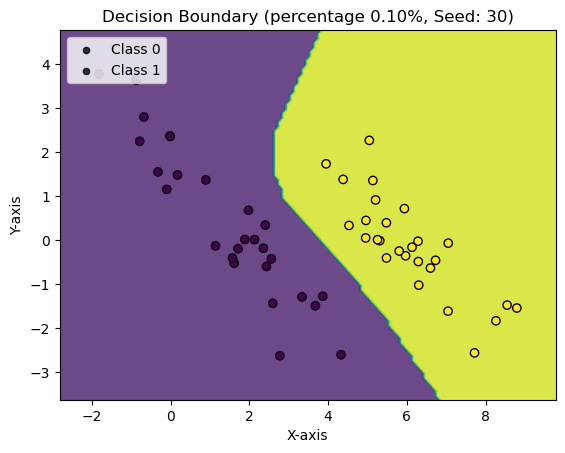

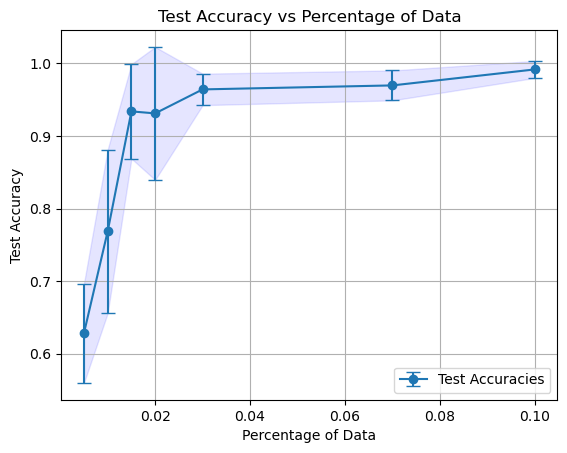

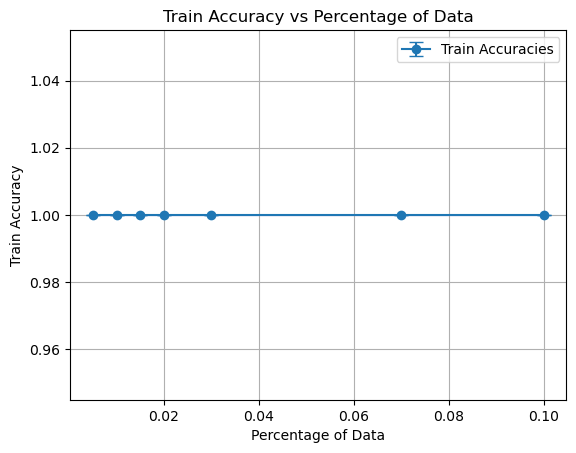

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.07,0.1]
seed_set = [10, 20, 30]
repeats = 3

params['lr'] = 0.1  
params['num_train'] = 50
params['early_stop_patience'] = 10

# Store results for each percentage
results = {}
results_train = {}
best_models = {}
data_loaders = {}

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accurecies = []
    best_accuracy = 0.0
    for _ , temp_seed in enumerate(seed_set):
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new = generate_fc_dnn(input_dim, new_n_classes, params, gaussian_init=False, activation_function = nn.ReLU)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(train_loader_transfer, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = test_loader_transfer
        val_loader_transfer_reduced = val_loader_transfer
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True, plot_boundary=False)
        
        test_accuracies.append(test_acc_new)
        train_accurecies.append(train_acc_new)

        print('eval on reduced train set')
        eval(model_new, device, train_loader_transfer_reduced, debug=True, classification_report_flag = True)
        print('eval on full test set')
        eval(model_new, device, test_loader_transfer_reduced, debug=True, classification_report_flag = True)
        plot_decision_boundary_dataloader(model_new, train_loader_transfer_reduced, n_classes=2, percentage = perc, Seed = temp_seed)

        '''# Check if this model is the best-performing for this percentage
        if train_acc_new > best_accuracy:
            best_accuracy = train_acc_new
            best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)\
         '''   
    
    results[perc] = test_accuracies
    results_train[perc] = train_accurecies

# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results[perc]) for perc in percentages]
stds = [np.std(results[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


## Only heads and data for new classes

now with balanced classes

Percentage: 0.005
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 45.83%
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 66.67%
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 67.50%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 64.17%
val_acc: 0.6416666666666667, max_val_acc: 0.675, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 57.50%
val_acc: 0.575, max_val_acc: 0.675, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 55.00%
val_acc: 0.55, max_val_acc: 0.675, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 51.67%
val_acc: 0.5166666666666667, max_val_acc: 0.675, no_improve_epochs: 4
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 45.00%
val_acc: 0.45, max_val_acc: 0.675, no_improve_epochs: 5
Early stopping invoked.
eval on reduced t

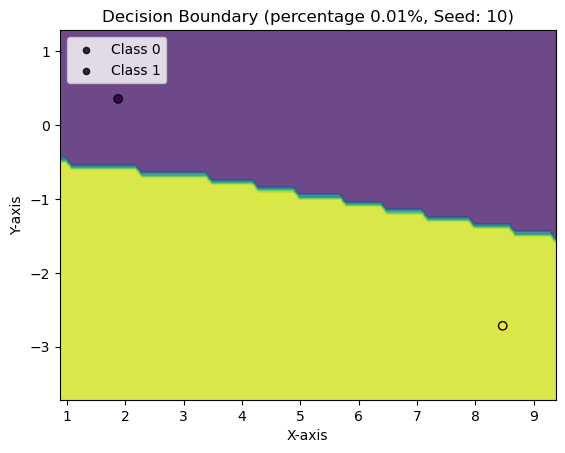

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 31.67%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 80.00%
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 63.33%
val_acc: 0.6333333333333333, max_val_acc: 0.8, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.8, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 50.00%
Validation Accuracy: 75.83%
val_acc: 0.7583333333333333, max_val_acc: 0.8, no_improve_epochs: 3
Epoch: 5 	Training Accuracy: 50.00%
Validation Accuracy: 85.83%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 7 	Training Accuracy: 50.00%
Validation Accuracy: 69.17%
val_acc: 0.6916666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 50.00%
Validation Accuracy: 50.00%
val_acc: 0.5, max_val_acc: 0.9916666666666667, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 50

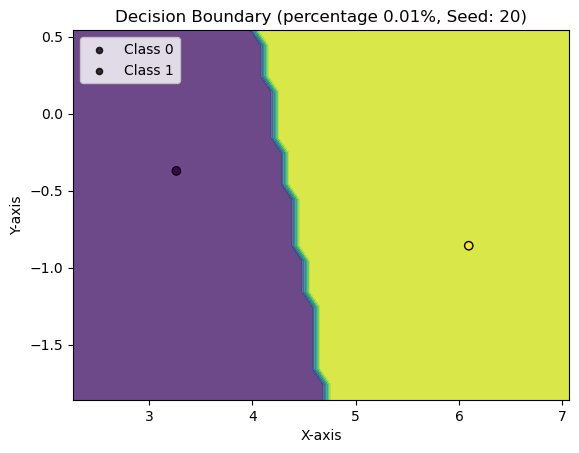

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 100.00%
Validation Accuracy: 69.17%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 68.33%
val_acc: 0.6833333333333333, max_val_acc: 0.6916666666666667, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 70.83%
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 71.67%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 74.17%
val_acc: 0.7416666666666667, max_val_acc: 0.7416666666666667, no_improve_epochs: 3
Epoch: 9 	Training Accuracy: 100.

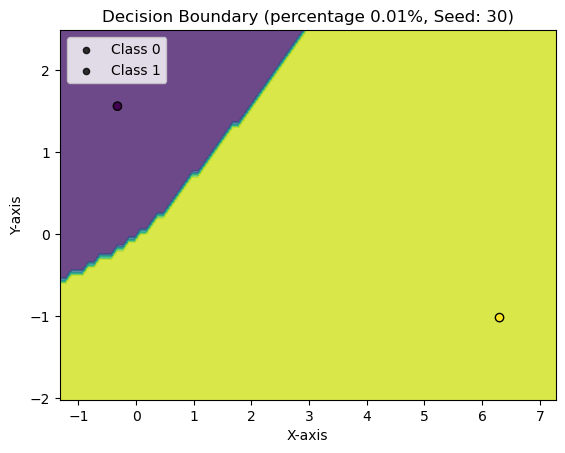

Percentage: 0.01
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 77.50%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 72.50%
val_acc: 0.725, max_val_acc: 0.775, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 62.50%
val_acc: 0.625, max_val_acc: 0.775, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 63.33%
val_acc: 0.6333333333333333, max_val_acc: 0.775, no_improve_epochs: 3
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 70.00%
val_acc: 0.7, max_val_acc: 0.775, no_improve_epochs: 4
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 81.67%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 84.17%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 84.17%
val_acc: 0.8416666666666667, max_val_acc: 0.8416666666666667, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 100

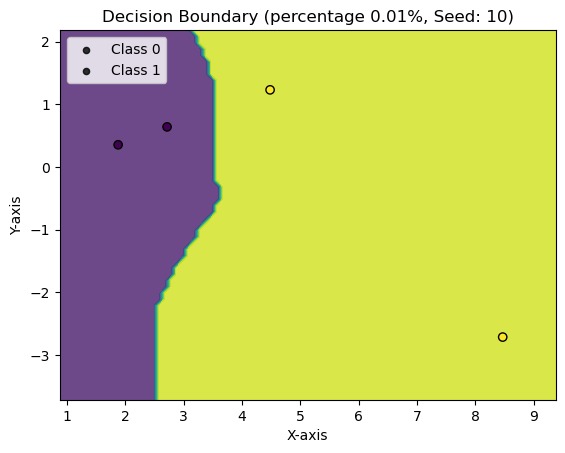

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 33.33%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 68.33%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 68.33%
val_acc: 0.6833333333333333, max_val_acc: 0.6833333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 68.33%
val_acc: 0.6833333333333333, max_val_acc: 0.6833333333333333, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 62.50%
val_acc: 0.625, max_val_acc: 0.6833333333333333, no_improve_epochs: 3
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 67.50%
val_acc: 0.675, max_val_acc: 0.6833333333333333, no_improve_epochs: 4
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 68.33%
val_acc: 0.6833333333333333, max_val_acc: 0.6833333333333333, no_improve_epochs: 5
Early stopping invoked.
eval on reduced train set

Average loss: 0.1919, Accuracy: 4.0/4 (100%)

             

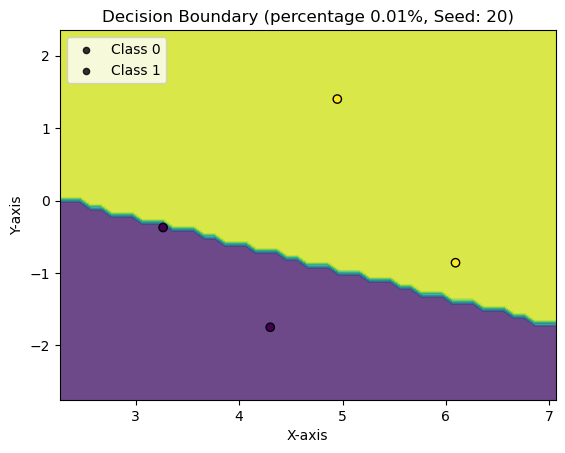

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 100.00%
Validation Accuracy: 66.67%
Epoch: 1 	Training Accuracy: 100.00%
Validation Accuracy: 72.50%
Epoch: 2 	Training Accuracy: 100.00%
Validation Accuracy: 75.00%
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 75.00%
val_acc: 0.75, max_val_acc: 0.75, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 75.83%
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 75.83%
val_acc: 0.7583333333333333, max_val_acc: 0.7583333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 75.83%
val_acc: 0.7583333333333333, max_val_acc: 0.7583333333333333, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 77.50%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 77.50%
val_acc: 0.775, max_val_acc: 0.775, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 77.50%
val_acc: 0.775, max_va

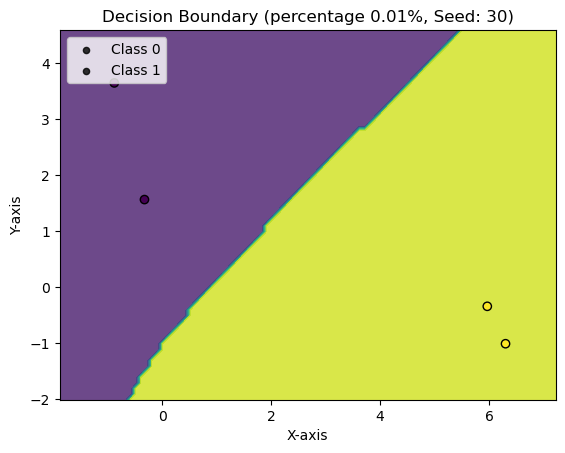

Percentage: 0.015
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 65.83%
Epoch: 2 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
val_acc: 0.44166666666666665, max_val_acc: 0.6583333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 50.00%
Validation Accuracy: 44.17%
val_acc: 0.44166666666666665, max_val_acc: 0.6583333333333333, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 87.50%
Validation Accuracy: 86.67%
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 96.67%
Epoch: 6 	Training Accuracy: 75.00%
Validation Accuracy: 85.83%
val_acc: 0.8583333333333333, max_val_acc: 0.9666666666666667, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 75.00%
Validation Accuracy: 85.00%
val_acc: 0.85, max_val_acc: 0.9666666666666667, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 87.50%
Validation Accuracy: 94.17%
val_acc: 0.9416666666666667, max_val

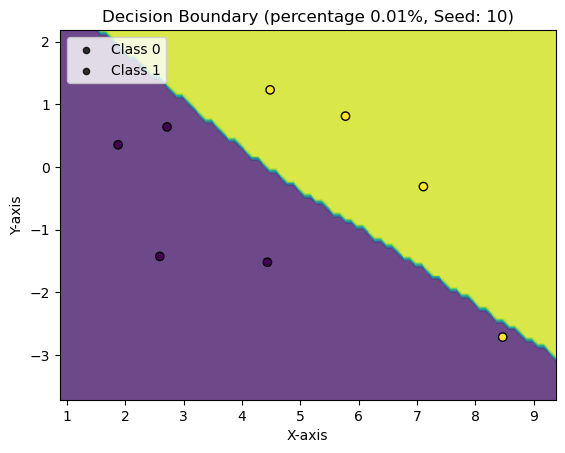

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 63.33%
Epoch: 1 	Training Accuracy: 62.50%
Validation Accuracy: 70.00%
Epoch: 2 	Training Accuracy: 62.50%
Validation Accuracy: 70.83%
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 77.50%
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 80.00%
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 82.50%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 75.00%
Validation Accuracy: 85.00%
val_acc: 0.85, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 75.00%
Validation Accuracy: 84.17%
val_acc: 0.8416666666666667, max_val_acc: 0.9833333333333333, no_improve_epochs: 3
Epoch: 10 	Training Accuracy: 75.00%
Validation Accuracy: 87.50%
val_acc:

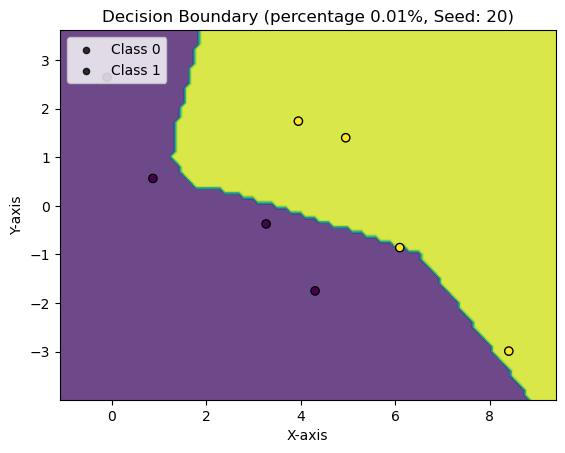

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 62.50%
Validation Accuracy: 60.83%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 75.00%
Validation Accuracy: 70.83%
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 75.00%
Epoch: 5 	Training Accuracy: 75.00%
Validation Accuracy: 78.33%
Epoch: 6 	Training Accuracy: 87.50%
Validation Accuracy: 80.00%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 85.83%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 89.17%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 89.17%
val_acc: 0.8916666666666667, max_val_acc: 0.8916666666666667, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 86.67%
val_acc: 0.8666666666666667, max_val_acc: 0.8916666666666667, no_improve_epochs: 2
Epoch: 11 	Training Accuracy: 100.00%
Validation Accuracy: 85.83%
val_acc: 

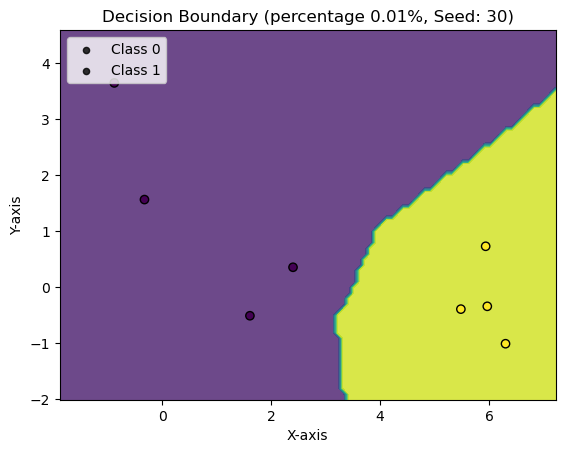

Percentage: 0.02
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 80.00%
Validation Accuracy: 75.83%
Epoch: 2 	Training Accuracy: 70.00%
Validation Accuracy: 42.50%
val_acc: 0.425, max_val_acc: 0.7583333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 90.00%
Validation Accuracy: 64.17%
val_acc: 0.6416666666666667, max_val_acc: 0.7583333333333333, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 90.00%
Validation Accuracy: 80.00%
Epoch: 5 	Training Accuracy: 70.00%
Validation Accuracy: 75.83%
val_acc: 0.7583333333333333, max_val_acc: 0.8, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 80.00%
Validation Accuracy: 78.33%
val_acc: 0.7833333333333333, max_val_acc: 0.8, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 80.00%
Validation Accuracy: 85.00%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 95.00%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
E

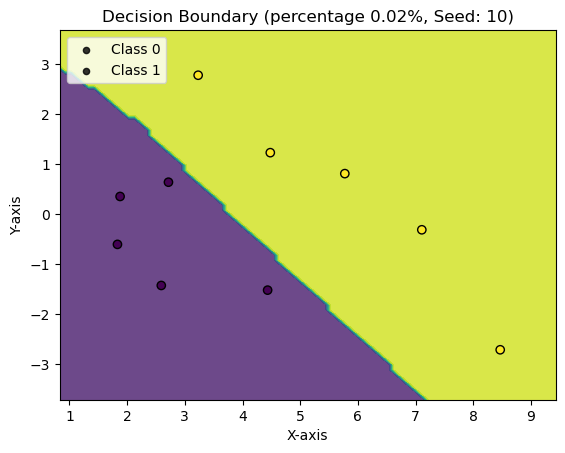

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
val_acc: 0.5583333333333333, max_val_acc: 0.5583333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 60.00%
Validation Accuracy: 72.50%
Epoch: 3 	Training Accuracy: 80.00%
Validation Accuracy: 82.50%
Epoch: 4 	Training Accuracy: 70.00%
Validation Accuracy: 88.33%
Epoch: 5 	Training Accuracy: 80.00%
Validation Accuracy: 91.67%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 90.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.98333333333333

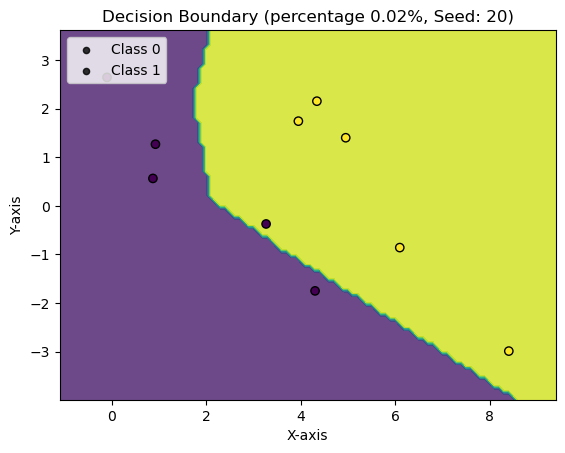

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 60.00%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 60.00%
Validation Accuracy: 60.00%
Epoch: 2 	Training Accuracy: 70.00%
Validation Accuracy: 70.00%
Epoch: 3 	Training Accuracy: 70.00%
Validation Accuracy: 70.83%
Epoch: 4 	Training Accuracy: 70.00%
Validation Accuracy: 75.83%
Epoch: 5 	Training Accuracy: 70.00%
Validation Accuracy: 78.33%
Epoch: 6 	Training Accuracy: 90.00%
Validation Accuracy: 82.50%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 86.67%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 86.67%
val_acc: 0.8666666666666667, max_val_acc: 0.8666666666666667, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 85.83%
val_acc: 0.8583333333333333, max_val_acc: 0.8666666666666667, no_improve_epochs: 2
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 85.00%
val_acc: 0.85, max_val_acc: 0.8666666666666667, no_improve_epochs: 3
Epoch:

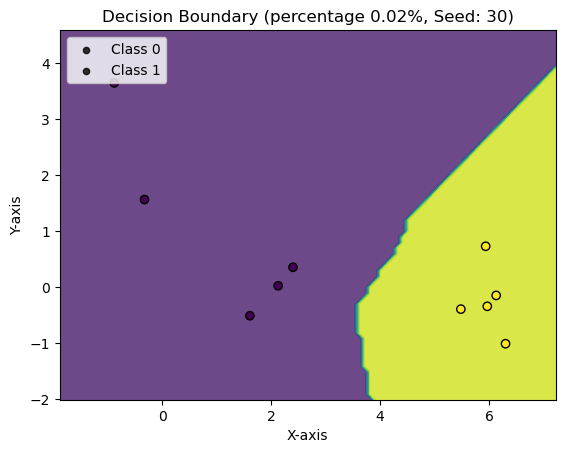

Percentage: 0.03
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 55.83%
Epoch: 1 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 50.83%
val_acc: 0.5083333333333333, max_val_acc: 0.5666666666666667, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 62.50%
Validation Accuracy: 50.00%
val_acc: 0.5, max_val_acc: 0.5666666666666667, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 75.00%
Validation Accuracy: 65.00%
Epoch: 5 	Training Accuracy: 87.50%
Validation Accuracy: 79.17%
Epoch: 6 	Training Accuracy: 68.75%
Validation Accuracy: 75.00%
val_acc: 0.75, max_val_acc: 0.7916666666666666, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 68.75%
Validation Accuracy: 75.00%
val_acc: 0.75, max_val_acc: 0.7916666666666666, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 81.25%
Validation Accuracy: 80.83%
Epoch: 9 	Training Accuracy: 93.75%
Validation Accuracy: 87.50%
Epoc

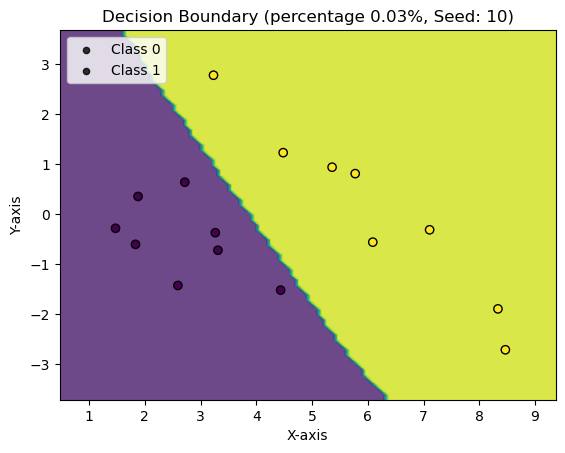

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 71.67%
Epoch: 1 	Training Accuracy: 87.50%
Validation Accuracy: 78.33%
Epoch: 2 	Training Accuracy: 75.00%
Validation Accuracy: 78.33%
val_acc: 0.7833333333333333, max_val_acc: 0.7833333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 81.25%
Validation Accuracy: 90.00%
Epoch: 4 	Training Accuracy: 87.50%
Validation Accuracy: 90.00%
val_acc: 0.9, max_val_acc: 0.9, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 87.50%
Validation Accuracy: 90.83%
Epoch: 6 	Training Accuracy: 87.50%
Validation Accuracy: 96.67%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
val_acc: 0.9916666666666667, max_val

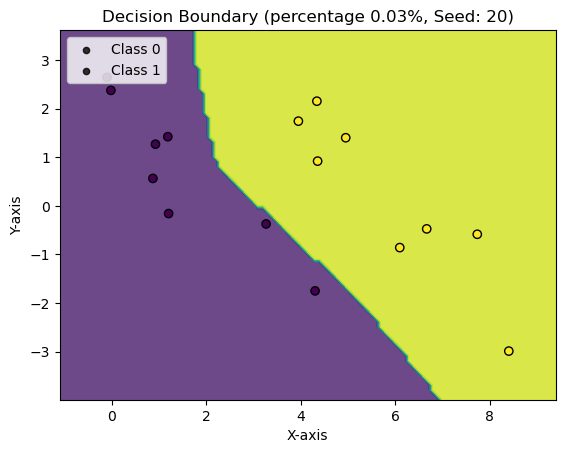

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 62.50%
Validation Accuracy: 59.17%
Epoch: 1 	Training Accuracy: 68.75%
Validation Accuracy: 74.17%
Epoch: 2 	Training Accuracy: 93.75%
Validation Accuracy: 91.67%
Epoch: 3 	Training Accuracy: 93.75%
Validation Accuracy: 90.83%
val_acc: 0.9083333333333333, max_val_acc: 0.9166666666666666, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 91.67%
val_acc: 0.9166666666666666, max_val_acc: 0.9166666666666666, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 89.17%
val_acc: 0.8916666666666667, max_val_acc: 0.9166666666666666, no_improve_epochs: 3
Epoch: 6 	Training Accuracy: 93.75%
Validation Accuracy: 89.17%
val_acc: 0.8916666666666667, max_val_acc: 0.9166666666666666, no_improve_epochs: 4
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 93.33%
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 95.83%
Epoch: 9 	Training Accuracy: 100.00%
V

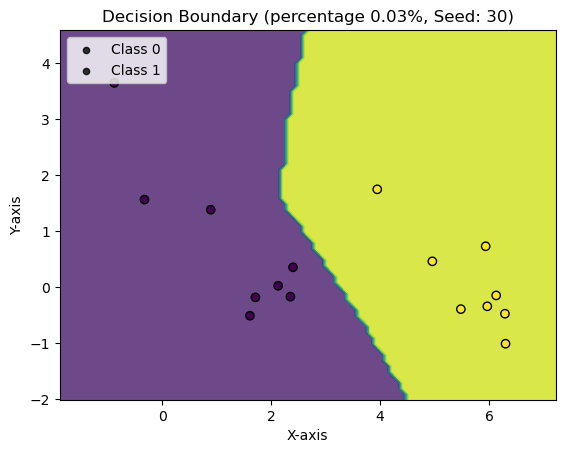

Percentage: 0.07
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 92.11%
Validation Accuracy: 90.83%
Epoch: 1 	Training Accuracy: 71.05%
Validation Accuracy: 83.33%
val_acc: 0.8333333333333334, max_val_acc: 0.9083333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 94.74%
Validation Accuracy: 97.50%
Epoch: 3 	Training Accuracy: 92.11%
Validation Accuracy: 88.33%
val_acc: 0.8833333333333333, max_val_acc: 0.975, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 94.74%
Validation Accuracy: 92.50%
val_acc: 0.925, max_val_acc: 0.975, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
val_acc: 0.9916666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9916666666666667

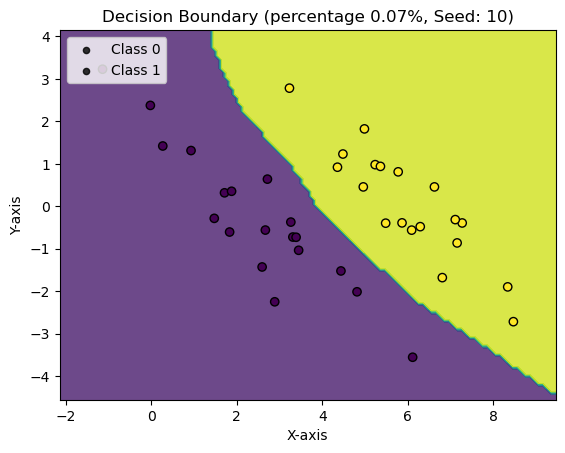

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 52.63%
Validation Accuracy: 60.83%
Epoch: 1 	Training Accuracy: 71.05%
Validation Accuracy: 86.67%
Epoch: 2 	Training Accuracy: 86.84%
Validation Accuracy: 81.67%
val_acc: 0.8166666666666667, max_val_acc: 0.8666666666666667, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 97.37%
Validation Accuracy: 99.17%
Epoch: 4 	Training Accuracy: 86.84%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 89.47%
Validation Accuracy: 94.17%
val_acc: 0.9416666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 89.47%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9916666666666667, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9916666666666667, no_improve_epochs: 4
Epoch: 8 	Training Acc

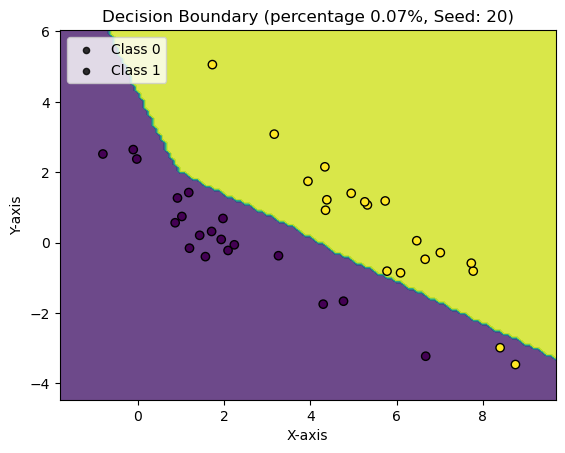

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 65.79%
Validation Accuracy: 75.83%
Epoch: 1 	Training Accuracy: 65.79%
Validation Accuracy: 77.50%
Epoch: 2 	Training Accuracy: 92.11%
Validation Accuracy: 89.17%
Epoch: 3 	Training Accuracy: 84.21%
Validation Accuracy: 85.83%
val_acc: 0.8583333333333333, max_val_acc: 0.8916666666666667, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 5 	Training Accuracy: 97.37%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 94.74%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 94.74%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9833333333333333, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 100.00%
Validation Accuracy: 95.00%
val_acc: 0.95, max_val_acc: 0.9833333333

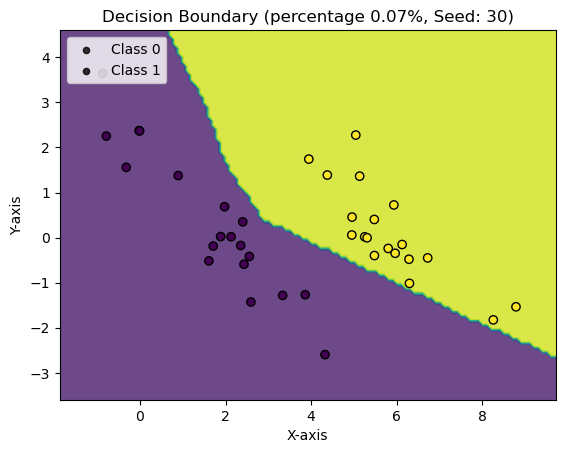

Percentage: 0.1
Repeat: 0, with seed 10 =========================
Epoch: 0 	Training Accuracy: 61.11%
Validation Accuracy: 72.50%
Epoch: 1 	Training Accuracy: 72.22%
Validation Accuracy: 80.83%
Epoch: 2 	Training Accuracy: 72.22%
Validation Accuracy: 71.67%
val_acc: 0.7166666666666667, max_val_acc: 0.8083333333333333, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 94.44%
Validation Accuracy: 97.50%
Epoch: 4 	Training Accuracy: 90.74%
Validation Accuracy: 94.17%
val_acc: 0.9416666666666667, max_val_acc: 0.975, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 87.04%
Validation Accuracy: 93.33%
val_acc: 0.9333333333333333, max_val_acc: 0.975, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 94.44%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.975, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 98.15%
Validation Accuracy: 97.50%
val_acc: 0.975, max_val_acc: 0.975, no_improve_epochs: 4
Epoch: 8 	Training Accuracy: 98.15%
Validation Accuracy: 98.33%
Epoch: 9

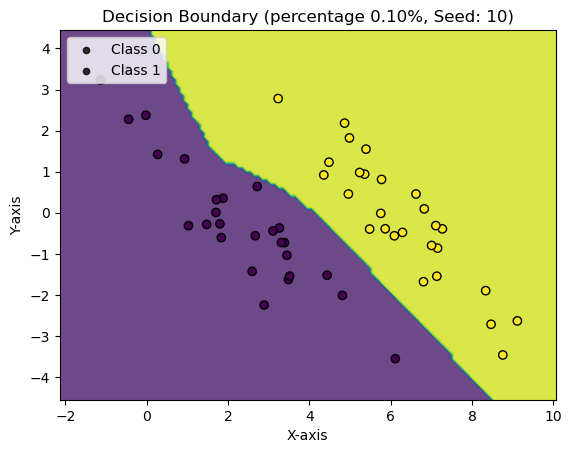

Repeat: 1, with seed 20 =========================
Epoch: 0 	Training Accuracy: 51.85%
Validation Accuracy: 60.83%
Epoch: 1 	Training Accuracy: 85.19%
Validation Accuracy: 80.00%
Epoch: 2 	Training Accuracy: 94.44%
Validation Accuracy: 97.50%
Epoch: 3 	Training Accuracy: 88.89%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.975, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 90.74%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.975, no_improve_epochs: 2
Epoch: 5 	Training Accuracy: 98.15%
Validation Accuracy: 99.17%
Epoch: 6 	Training Accuracy: 100.00%
Validation Accuracy: 99.17%
val_acc: 0.9916666666666667, max_val_acc: 0.9916666666666667, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch: 8 	Training Accuracy: 96.30%
Validation Accuracy: 98.33%
val_acc: 0.9833333333333333, max_val_acc: 1.0, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 96.30%
Validation Accuracy: 98.33%
val_acc: 0.98333

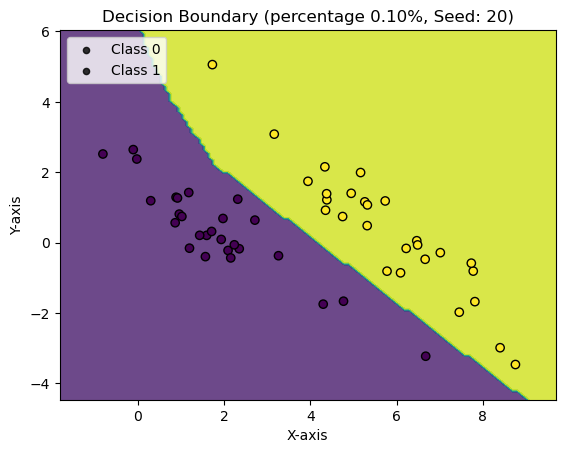

Repeat: 2, with seed 30 =========================
Epoch: 0 	Training Accuracy: 50.00%
Validation Accuracy: 56.67%
Epoch: 1 	Training Accuracy: 83.33%
Validation Accuracy: 83.33%
Epoch: 2 	Training Accuracy: 81.48%
Validation Accuracy: 80.00%
val_acc: 0.8, max_val_acc: 0.8333333333333334, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 100.00%
Validation Accuracy: 98.33%
Epoch: 4 	Training Accuracy: 96.30%
Validation Accuracy: 95.83%
val_acc: 0.9583333333333334, max_val_acc: 0.9833333333333333, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 96.30%
Validation Accuracy: 92.50%
val_acc: 0.925, max_val_acc: 0.9833333333333333, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 98.15%
Validation Accuracy: 93.33%
val_acc: 0.9333333333333333, max_val_acc: 0.9833333333333333, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 100.00%
Validation Accuracy: 96.67%
val_acc: 0.9666666666666667, max_val_acc: 0.9833333333333333, no_improve_epochs: 4
Epoch: 8 	Training Accuracy: 100.00%
Validation A

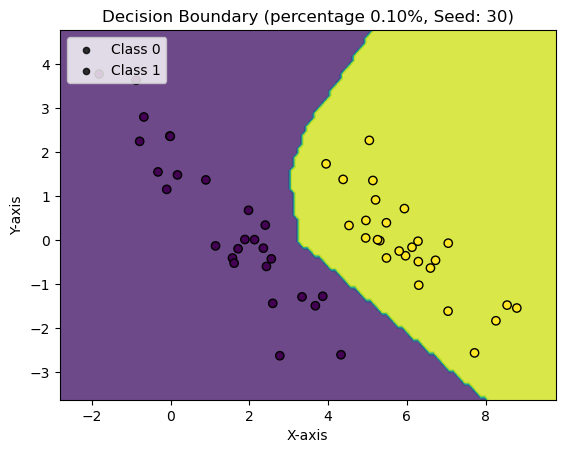

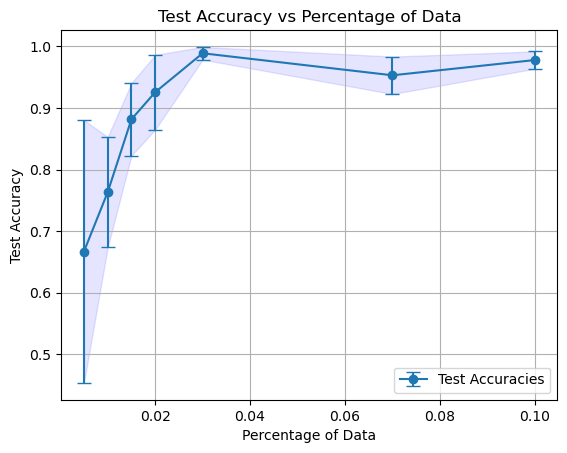

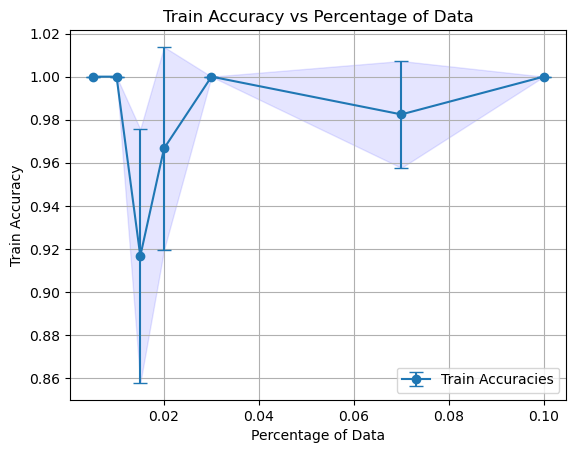

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.07,0.1]
seed_set = [10, 20, 30]
repeats = 3

params['lr'] = 0.1  
params['num_train'] = 50
params['early_stop_patience'] = 5

# Store results for each percentage
results = {}
results_train = {}
best_models = {}
data_loaders = {}

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accurecies = []
    best_accuracy = 0.0
    for _ , temp_seed in enumerate(seed_set):
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new = generate_fc_dnn(input_dim, new_n_classes, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth-1) not in name:
                model_new._parameters[name] = param

        # now we freeze the copied weights (first layer)
        for name, param in model.named_parameters():
            if "linear" + str(depth-1) not in name:
                param.requires_grad = False
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(train_loader_transfer, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = test_loader_transfer
        val_loader_transfer_reduced = val_loader_transfer
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True, plot_boundary=False)
        
        test_accuracies.append(test_acc_new)
        train_accurecies.append(train_acc_new)

        print('eval on reduced train set')
        eval(model_new, device, train_loader_transfer_reduced, debug=True, classification_report_flag = True)
        print('eval on full test set')
        eval(model_new, device, test_loader_transfer_reduced, debug=True, classification_report_flag = True)
        plot_decision_boundary_dataloader(model_new, train_loader_transfer_reduced, n_classes=2, percentage = perc, Seed = temp_seed)

        '''# Check if this model is the best-performing for this percentage
        if train_acc_new > best_accuracy:
            best_accuracy = train_acc_new
            best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)\
         '''   
    
    results[perc] = test_accuracies
    results_train[perc] = train_accurecies

# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results[perc]) for perc in percentages]
stds = [np.std(results[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
print(model_new)

Sequential(
  (linear0): Linear(in_features=2, out_features=20, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=20, out_features=2, bias=True)
  (activation1): LogSoftmax(dim=1)
)


In [26]:
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:
        #model_new._parameters[name] = param
        print('layer name: ', name)
        


layer name:  linear0.weight
layer name:  linear0.bias
